<a href="https://colab.research.google.com/github/oscaralateras/lin-alg-energy-segmentation/blob/main/LinAlgProject.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Linear Algebra to Solve Business Problems with Machine Learning

**Project Objective:** This notebook demonstrates how core linear-algebra concepts, such as Principal Component Analysis (PCA) and K-Means, can be applied to solve practical business problems through machine learning.

**Methodology:**
* We will use daily electricity-usage data to segment households and uncover underlying consumption patterns.
* The primary techniques employed will be a manual implementation of **Principal Component Analysis (PCA)** for dimensionality reduction and **K-Means Clustering** for customer segmentation.

**Dataset:**
* The analysis is based on daily electricity usage data from the **AusGrid Solar Home Electricity Dataset**.
* The data spans the period from **June 2012 to July 2013** and includes 300 residential customers.

**Business Application:**
* The insights gained from this analysis can inform a more effective and data-driven electricity pricing strategy.

## Section 1: Imports

In this section, we import the Python libraries that will be used throughout the notebook.
These libraries provide the core functionalities for data manipulation, numerical computation, and visualization.

- **NumPy** for efficient numerical and linear algebra operations.
- **Pandas** for loading, manipulating, and analyzing tabular data.
- **Matplotlib** for creating static, animated, and interactive visualizations.
- **Pathlib** for object-oriented handling of filesystem paths, ensuring cross-platform compatibility.

In [1]:
# Import foundational libraries for data manipulation, computation, and visualization
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

## Section 2: Pre-processing Functions

The code block that follows converts the raw AusGrid CSV into a clean, analysis-ready matrix.
It is organised as small, single-purpose helpers plus one driver that chains them together:

| Step | Function | What it does |
|------|----------|--------------|
| 1 | **`load_and_filter_data`** | Reads the CSV, keeps only “GC” (General Consumption) rows, drops metadata columns, and casts energy values to float. |
| 2 | **`handle_na_values`** | Replaces any missing half-hour readings with the column mean so PCA isn’t tripped up by NaNs. |
| 3 | **`filter_by_data_quality`** | Discards customers (and rows) whose profiles are >20 % all-zero, removing uninformative data. |
| 4 | **`aggregate_and_standardize`** | Averages each customer’s daily load profile, then z-scores every time-of-day column (zero-mean, unit-variance). |
| 5 | **`run_preprocessing_pipeline`** | Orchestrates the four steps above and returns both the raw mean profiles and the standardised matrix. |

These helpers isolate data-cleaning logic from the modelling code, making the notebook easier to follow and reuse.

In [2]:
# ==============================================================================
#  Helper Functions for Data Pre-processing
# ==============================================================================

def load_and_filter_data(file_path: Path, consumption_category: str = 'GC'):
    """
    Reads the raw AusGrid CSV, filters for a specific consumption category,
    and performs initial cleaning.

    Args:
        file_path (Path): The path to the input CSV file.
        consumption_category (str): The category to filter for (e.g., 'GC' for General Consumption).

    Returns:
        pd.DataFrame: A DataFrame with filtered data, dropped metadata columns,
                      and correctly typed energy readings.
    """
    # Read the CSV, skipping the first row which contains metadata.
    raw_df = pd.read_csv(file_path, header=1)

    # Define columns that contain metadata and are not needed for analysis.
    cols_to_drop = [
        'Generator Capacity',
        'Postcode',
        'Row Quality',
        'date',
        'Consumption Category'
    ]

    # Chain pandas operations for a fluent and readable workflow.
    filtered_df = (
        raw_df[raw_df['Consumption Category'] == consumption_category]
        .copy()
        .drop(columns=cols_to_drop)
    )

    # Convert all energy-reading columns to numeric type.
    # 'coerce' will turn any values that cannot be converted into NaN (Not a Number).
    energy_cols = filtered_df.columns.drop('Customer')
    filtered_df[energy_cols] = filtered_df[energy_cols].apply(pd.to_numeric, errors='coerce')

    return filtered_df

def handle_na_values(df: pd.DataFrame):
    """
    Identifies and fills NaN values in the energy columns of the DataFrame
    using the mean of each respective column.

    Args:
        df (pd.DataFrame): The input DataFrame with potential NaN values.

    Returns:
        tuple[pd.DataFrame, int]: A tuple containing:
            - pd.DataFrame: The DataFrame with NaNs filled.
            - int: The total count of NaN values that were replaced.
    """
    energy_cols = df.columns.drop('Customer')
    na_count = df[energy_cols].isna().sum().sum()

    if na_count > 0:
        # For each column, fill any NaN values with the column's mean.
        # Returning a new DataFrame is safer than using inplace=True.
        df[energy_cols] = df[energy_cols].fillna(df[energy_cols].mean())

    return df, na_count

def filter_by_data_quality(df: pd.DataFrame, zero_threshold: float = 0.20):
    """
    Filters out low-quality data in two steps:
    1. Removes customers whose daily readings are too frequently all-zero.
    2. Removes the remaining individual all-zero daily readings.

    Args:
        df (pd.DataFrame): The input DataFrame.
        zero_threshold (float): The maximum allowed percentage of all-zero days for a customer.

    Returns:
        pd.DataFrame: A DataFrame with low-quality customers and rows removed.
    """
    energy_cols = df.columns.drop('Customer')

    # Step 1: Identify and filter out customers with too many all-zero days.
    is_all_zero = df[energy_cols].eq(0).all(axis=1)

    # Calculate the percentage of all-zero days for each customer.
    # This works because in a boolean series, mean() treats True as 1 and False as 0.
    pct_zero_by_cust = is_all_zero.groupby(df['Customer']).mean()
    customers_to_keep = pct_zero_by_cust[pct_zero_by_cust <= zero_threshold].index

    df_good_cust = df[df['Customer'].isin(customers_to_keep)].copy()

    # Step 2: Remove the individual all-zero rows from the remaining "good" customers.
    is_all_zero_good = is_all_zero.loc[df_good_cust.index]
    df_no_zero_rows = df_good_cust[~is_all_zero_good]

    return df_no_zero_rows

def aggregate_and_standardize(df: pd.DataFrame):
    """
    Aggregates the data to create a mean daily profile for each customer,
    then standardizes the data using Z-score scaling.

    Args:
        df (pd.DataFrame): The cleaned daily readings DataFrame.

    Returns:
        tuple[pd.DataFrame, pd.DataFrame]: A tuple containing:
            - pd.DataFrame: The aggregated mean profiles (raw kWh).
            - pd.DataFrame: The Z-score standardized profiles.
    """
    energy_cols = df.columns.drop('Customer')

    # Group by customer and calculate the mean for each time slot.
    profiles = df.groupby('Customer')[energy_cols].mean().sort_index()

    # Z-score standardize the profiles: (value - mean) / std_dev.
    col_mean = profiles.mean(axis=0)
    col_std = profiles.std(axis=0, ddof=0) # Use population std dev.
    profiles_standardized = (profiles - col_mean) / col_std

    # 'X' is a conventional name for a feature matrix in machine learning.
    X_std = profiles_standardized

    return profiles, X_std

# ==============================================================================
#  Main Pipeline Orchestrator
# ==============================================================================

def run_preprocessing_pipeline(file_path: Path):
    """
    Orchestrates the entire data preprocessing pipeline.

    Args:
        file_path (Path): The path object for the input CSV file.

    Returns:
        tuple[pd.DataFrame, pd.DataFrame]: A tuple containing:
            - pd.DataFrame: The final, aggregated mean profiles (raw kWh).
            - pd.DataFrame: The final, Z-score standardized profiles for modeling.
    """
    print("Starting preprocessing pipeline...")

    if not file_path.exists():
        raise FileNotFoundError(f'CSV file not found at: {file_path}')

    # --- Chain of preprocessing steps ---
    df_loaded = load_and_filter_data(file_path)
    print(f"1. Loaded and filtered data. Shape: {df_loaded.shape}")

    df_cleaned, na_count = handle_na_values(df_loaded)
    print(f"2. Found and imputed {na_count:,} NaN values.")

    df_quality_filtered = filter_by_data_quality(df_cleaned)
    print(f"3. Filtered for data quality. Shape: {df_quality_filtered.shape}")

    final_profiles, X_std = aggregate_and_standardize(df_quality_filtered)
    print(f"4. Aggregated and standardized. Final matrix shape: {final_profiles.shape}")

    return final_profiles, X_std

In [3]:
# Define the path to the dataset using Path for cross-platform compatibility.
# All constants should be in uppercase.
DATA_FILE_PATH = Path('/content/2012-2013 Solar home electricity data v2.csv')

# Use a try...except block to run the pipeline gracefully.
try:
    # Execute the main pipeline function to get the analysis-ready data.
    final_profiles, X_std = run_preprocessing_pipeline(DATA_FILE_PATH)

    print("\n✅ Preprocessing complete.")

    # --- Display a preview of the results ---

    print("\nPreview of cleaned & aggregated profiles (raw average kWh):")
    # .head() is an idiomatic way to see the first 5 rows.
    display(final_profiles.head().iloc[:, :10])

    print("\nPreview of Z-score standardized profiles (ready for PCA/K-Means):")
    display(X_std.head().iloc[:, :10])

except FileNotFoundError as e:
    # Catch a specific error for a more precise message.
    print(f"\n❌ Error: Input file not found. {e}")
except Exception as e:
    # Catch any other unexpected exception from the pipeline.
    print(f"\n❌ An unexpected error occurred during preprocessing: {e}")

Starting preprocessing pipeline...
1. Loaded and filtered data. Shape: (109419, 49)
2. Found and imputed 0 NaN values.
3. Filtered for data quality. Shape: (109390, 49)
4. Aggregated and standardized. Final matrix shape: (300, 48)

✅ Preprocessing complete.

Preview of cleaned & aggregated profiles (raw average kWh):


,0:30,1:00,1:30,2:00,2:30,3:00,3:30,4:00,4:30,5:00
Customer,,,,,,,,,,
1,0.237205,0.228825,0.220693,0.215778,0.203636,0.248071,0.790332,0.579085,0.168534,0.253329
2,0.210183,0.185327,0.178704,0.166176,0.166831,0.154366,0.153930,0.149930,0.149602,0.183940
3,0.146493,0.116430,0.097466,0.080526,0.067989,0.066044,0.062764,0.064433,0.069844,0.075033
4,0.122540,0.114627,0.109523,0.109726,0.106537,0.107447,0.109441,0.109104,0.107964,0.106901
5,0.131244,0.122945,0.119326,0.115562,0.115000,0.113329,0.102279,0.102159,0.099742,0.105515



Preview of Z-score standardized profiles (ready for PCA/K-Means):


,0:30,1:00,1:30,2:00,2:30,3:00,3:30,4:00,4:30,5:00
Customer,,,,,,,,,,
1,-0.051204,0.000759,0.038717,0.085465,0.044466,0.352388,3.675522,2.818730,-0.115715,0.466342
2,-0.170531,-0.203286,-0.190244,-0.219539,-0.163858,-0.215587,-0.205006,-0.234318,-0.253307,-0.028857
3,-0.451775,-0.526483,-0.633229,-0.746202,-0.723327,-0.750937,-0.760895,-0.842549,-0.832962,-0.806084
4,-0.557550,-0.534940,-0.567481,-0.566651,-0.505136,-0.499982,-0.476279,-0.524754,-0.555915,-0.578652
5,-0.519114,-0.495921,-0.514027,-0.530768,-0.457233,-0.464328,-0.519948,-0.574163,-0.615669,-0.588545


## Section 3: Principal Component Analysis (PCA)

In this section we **manually** implement PCA to compress the
48-dimensional (z-scored) load-profile matrix into a handful of orthogonal
directions that capture the bulk of variance.
Steps:

1.  **Covariance matrix** – quantify how every half-hour slot co-varies.
2.  **Eigen-decomposition** – extract eigenvalues (variances) and
    eigenvectors (axes).
3.  **Scree plot** – pick the smallest number of components that explains a
    chosen share of variance (e.g. 80 %).
4.  **Projection** – map each customer into this lower-dimensional PC space.
5.  **Loadings plot** – inspect which time-of-day slots drive each PC.

In [4]:
# ==============================================================================
#  Helper Functions for Principal Component Analysis (PCA)
# ==============================================================================

def calculate_covariance_matrix(X_std: pd.DataFrame) -> np.ndarray:
    """
    Calculates the covariance matrix from a standardized data matrix.

    Args:
        X_std (pd.DataFrame): Standardized data (mean=0). Samples are rows, features are columns.

    Returns:
        np.ndarray: The resulting covariance matrix.
    """
    X_np = X_std.values
    n_samples = X_np.shape[0]
    # For mean-centered data, covariance matrix = (X^T * X) / (n-1)
    covariance_matrix = (1 / (n_samples - 1)) * (X_np.T @ X_np)
    return covariance_matrix

def calculate_eigens(cov_matrix: np.ndarray) -> tuple[np.ndarray, np.ndarray]:
    """
    Performs eigendecomposition on a covariance matrix and sorts the results.

    Args:
        cov_matrix (np.ndarray): A square covariance matrix.

    Returns:
        tuple[np.ndarray, np.ndarray]: Sorted eigenvalues and corresponding eigenvectors.
    """
    eigenvalues_complex, eigenvectors_complex = np.linalg.eig(cov_matrix)

    # For a real symmetric matrix, results are real. Discard tiny imaginary parts from numerical error.
    eigenvalues = np.real(eigenvalues_complex)
    eigenvectors = np.real(eigenvectors_complex)

    # Sort eigenvalues and eigenvectors in descending order.
    idx = eigenvalues.argsort()[::-1]
    return eigenvalues[idx], eigenvectors[:, idx]

def plot_scree_and_find_components(eigenvalues: np.ndarray, variance_threshold: float = 0.80) -> int:
    """
    Plots the explained variance (scree plot) and determines the number of
    components needed to meet a variance threshold.

    Args:
        eigenvalues (np.ndarray): Sorted eigenvalues.
        variance_threshold (float): The cumulative variance to be explained.

    Returns:
        int: The number of principal components required to meet the threshold.
    """
    total_variance = np.sum(eigenvalues)
    explained_variance_ratio = eigenvalues / total_variance
    cumulative_variance_ratio = np.cumsum(explained_variance_ratio)

    n_components = np.argmax(cumulative_variance_ratio >= variance_threshold) + 1

    plt.style.use('seaborn-v0_8-whitegrid')
    fig, ax = plt.subplots(figsize=(12, 7))

    ax.bar(range(1, len(eigenvalues) + 1), explained_variance_ratio, alpha=0.7, label='Individual Explained Variance', color='steelblue')
    ax.plot(range(1, len(eigenvalues) + 1), cumulative_variance_ratio, marker='o', linestyle='--', color='firebrick', label='Cumulative Explained Variance')

    ax.axhline(y=variance_threshold, color='green', linestyle=':', label=f'{variance_threshold:.0%} Variance Threshold')
    ax.axvline(x=n_components, color='purple', linestyle=':', label=f'{n_components} Components for {variance_threshold:.0%} Variance')

    ax.set_xlabel('Number of Principal Components')
    ax.set_ylabel('Proportion of Variance Explained')
    ax.set_title('Scree Plot for PCA', fontsize=16)
    ax.set_xticks(np.arange(0, len(eigenvalues) + 1, 5))
    ax.set_xlim(0.5, len(eigenvalues) + 0.5) # Give bars some space
    ax.legend(loc='center right')
    plt.tight_layout()
    plt.show()

    return n_components

def project_data(X_std: pd.DataFrame, eigenvectors: np.ndarray, n_components: int) -> pd.DataFrame:
    """
    Projects the original standardized data onto the principal component space.

    Args:
        X_std (pd.DataFrame): The original standardized data.
        eigenvectors (np.ndarray): The sorted eigenvectors (as columns).
        n_components (int): The number of principal components to project onto.

    Returns:
        pd.DataFrame: The dimensionally-reduced data.
    """
    X_np = X_std.values
    projection_matrix = eigenvectors[:, :n_components]
    X_pca_np = X_np.dot(projection_matrix)

    pca_cols = [f'PC{i+1}' for i in range(n_components)]
    return pd.DataFrame(X_pca_np, index=X_std.index, columns=pca_cols)

def plot_component_loadings(eigenvectors: np.ndarray, feature_names: list, n_components: int):
    """
    Visualizes the weights (loadings) of each original feature for each principal component.

    Args:
        eigenvectors (np.ndarray): The sorted eigenvectors.
        feature_names (list): The names of the original features (e.g., time slots).
        n_components (int): The number of components to visualize.
    """
    components = pd.DataFrame(eigenvectors[:, :n_components],
                              columns=[f'PC{i+1}' for i in range(n_components)],
                              index=feature_names)

    y_lims = (components.min().min() * 1.1, components.max().max() * 1.1)

    fig, axes = plt.subplots(n_components, 1, figsize=(14, n_components * 3.5), sharex=True)
    if n_components == 1:
        axes = [axes]

    time_labels = [f'{h:02d}:{m:02d}' for h in range(24) for m in (0, 30)]

    for i, ax in enumerate(axes):
        pc_name = f'PC{i+1}'
        loadings = components[pc_name]

        ax.plot(time_labels, loadings, marker='.', linestyle='-')
        ax.axhline(0, color='black', linestyle='--', alpha=0.5)
        ax.set_title(f'Loadings for {pc_name}')
        ax.set_ylabel('Loading Weight')
        ax.set_ylim(y_lims)

        # Improve x-axis readability by showing fewer labels
        ax.set_xticks(time_labels[::4]) # Show every 4th label (every 2 hours)
        ax.tick_params(axis='x', rotation=45)

    ax.set_xlabel('Time of Day')
    plt.tight_layout()
    plt.show()

# ==============================================================================
#  Main PCA Pipeline Orchestrator
# ==============================================================================

def run_pca_pipeline(X_std: pd.DataFrame, variance_threshold: float) -> pd.DataFrame:
    """
    Orchestrates the entire manual PCA pipeline.

    Args:
        X_std (pd.DataFrame): The standardized input data.
        variance_threshold (float): The target for cumulative explained variance.

    Returns:
        pd.DataFrame: The final, dimensionally-reduced DataFrame.
    """
    print("Starting PCA pipeline...")

    # 1. Covariance matrix
    cov_matrix = calculate_covariance_matrix(X_std)
    print(f"1. Calculated covariance matrix. Shape: {cov_matrix.shape}")

    # 2. Eigen-decomposition
    eigenvalues, eigenvectors = calculate_eigens(cov_matrix)
    print("2. Calculated and sorted eigenvalues/eigenvectors.")

    # 3. Scree plot and component selection
    n_components = plot_scree_and_find_components(eigenvalues, variance_threshold)
    print(f"3. Scree plot generated. Determined {n_components} components are needed.")

    # 4. Projection
    X_pca_df = project_data(X_std, eigenvectors, n_components)
    print(f"4. Projected data onto {n_components} principal components.")

    # 5. Loadings plot
    plot_component_loadings(eigenvectors, X_std.columns, n_components)
    print("5. Generated component loading plots for interpretation.")

    return X_pca_df

Starting PCA pipeline...
1. Calculated covariance matrix. Shape: (48, 48)
2. Calculated and sorted eigenvalues/eigenvectors.


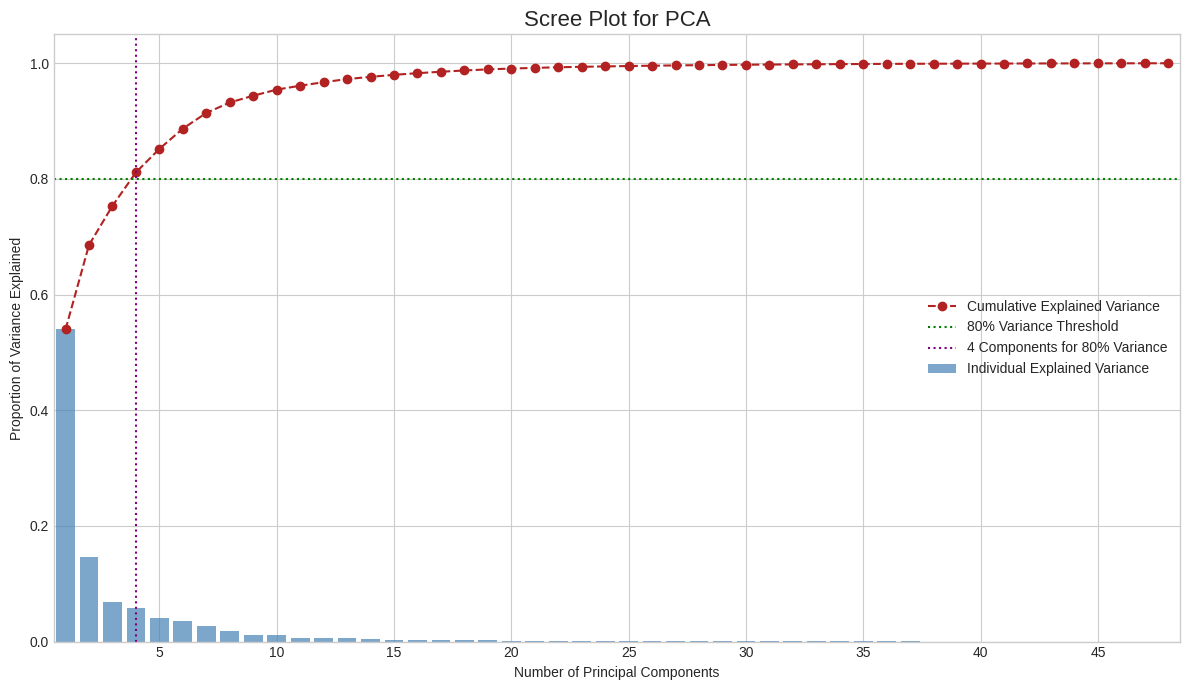

3. Scree plot generated. Determined 4 components are needed.
4. Projected data onto 4 principal components.


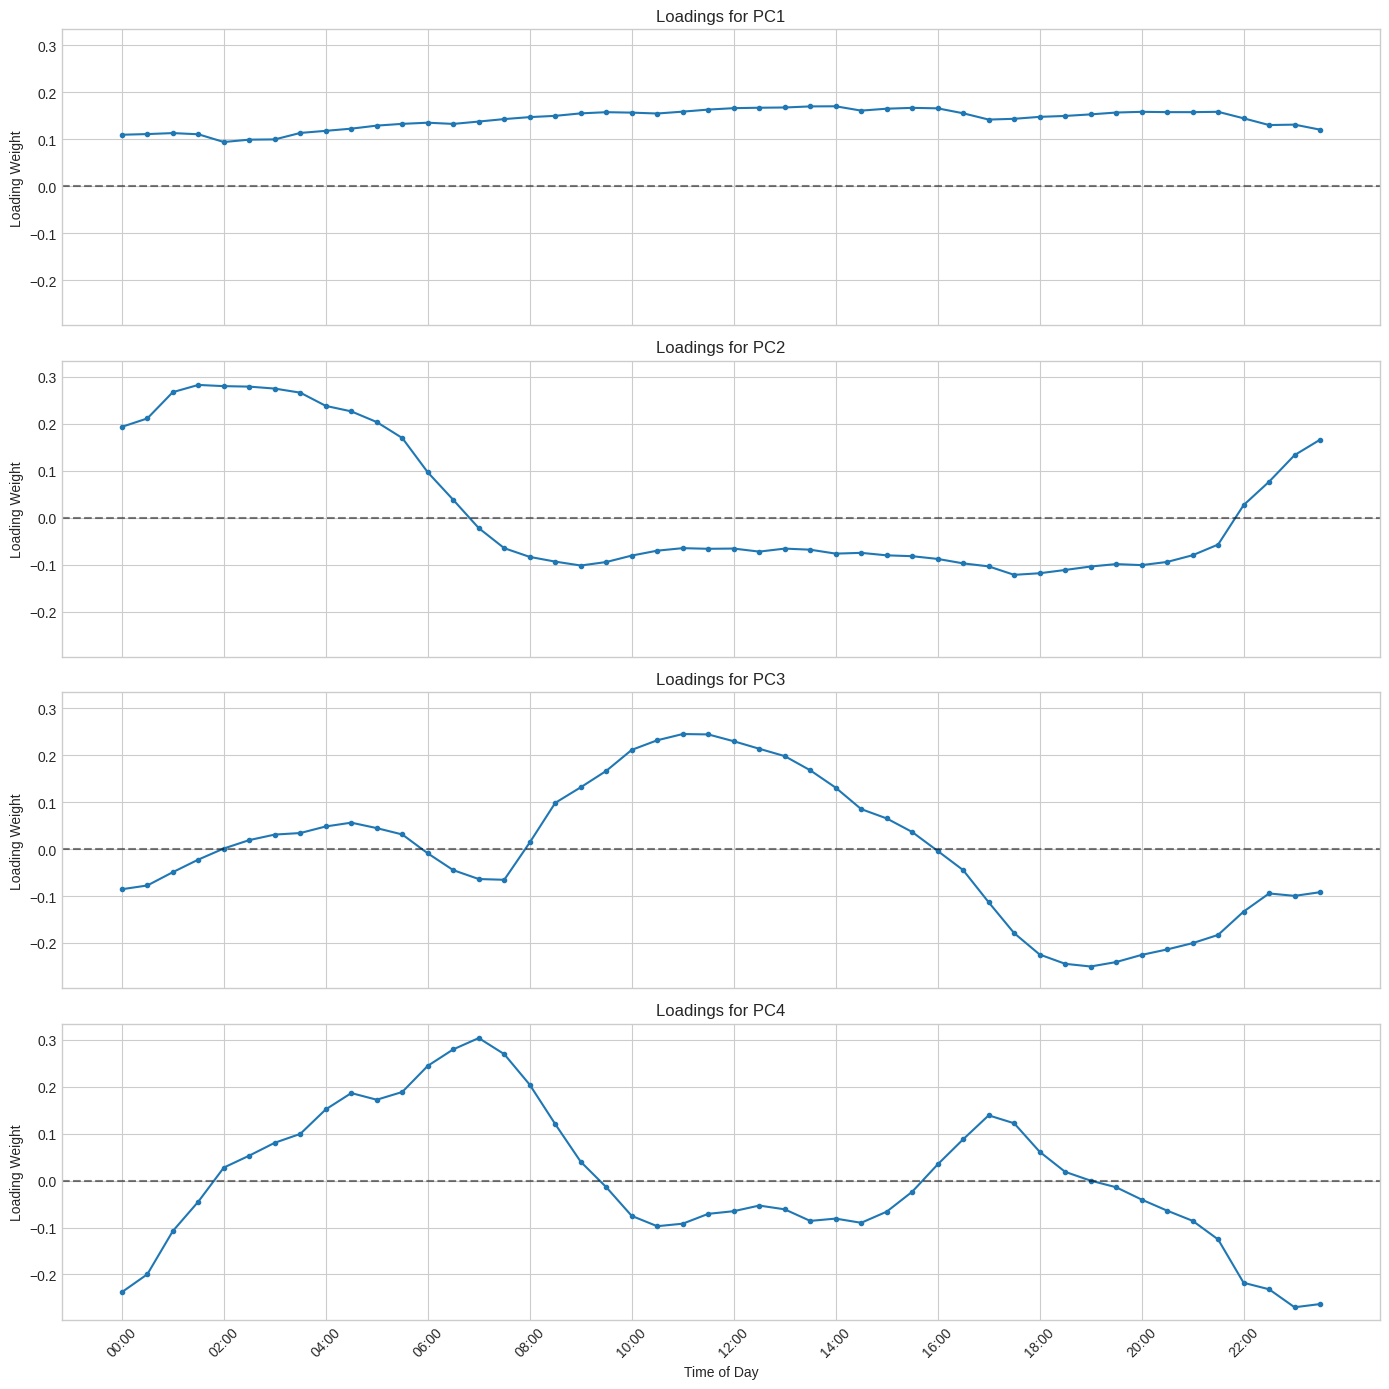

5. Generated component loading plots for interpretation.

✅ PCA pipeline completed successfully.

Preview of dimensionally-reduced data (4 components):


,PC1,PC2,PC3,PC4
Customer,,,,
1,-0.839152,5.179670,1.378952,1.147286
2,0.039868,-0.777031,-0.393870,-0.752068
3,-7.971796,0.932638,0.633477,-0.584657
4,-4.409624,-0.276240,0.045659,-0.089032
5,-3.475961,-0.793329,-0.765547,-0.008150


In [5]:
# Set the desired variance threshold for PCA.
# 80% is a common starting point, balancing information retention and dimensionality reduction.
VARIANCE_TARGET = 0.80

# Execute the PCA pipeline within a try-except block to handle potential errors gracefully.
try:
    # The main function orchestrates all the PCA steps defined above.
    X_pca_df = run_pca_pipeline(X_std, variance_threshold=VARIANCE_TARGET)

    print("\n✅ PCA pipeline completed successfully.")

    # Display a preview of the resulting dimensionally-reduced data.
    # The index (Customer) is preserved, and columns are now Principal Components.
    print(f"\nPreview of dimensionally-reduced data ({X_pca_df.shape[1]} components):")
    display(X_pca_df.head())

# It's good practice to catch specific errors if you can anticipate them.
except NameError:
    print("\n❌ Error: The 'X_std' DataFrame was not found. Please ensure the preprocessing section has been run successfully.")
# A general exception catch handles any other unexpected issues.
except Exception as e:
    print(f"\n❌ An unexpected error occurred during the PCA pipeline: {e}")

## Section 4: K-Means Clustering

After reducing dimensionality with PCA, we partition households into *K* clusters whose members share similar daily-usage signatures.

**What we’ll do in this section**

1. **K-Means**  
   &nbsp;&nbsp;• Initialise *K* random centroids  
   &nbsp;&nbsp;• Iteratively assign points → recompute centroids → stop when centroids barely move  
   &nbsp;&nbsp;• Return cluster labels and total squared error (*inertia*)

2. **Elbow method**  
   Run K-Means for a range of *K* (2 - 10) and plot inertia.  
   The “elbow” — where inertia stops dropping steeply — suggests a good *K*.

3. **Interactive choice of *K***  
   Prompt the user to pick *K* from the elbow plot, then recompute clusters with verbose convergence logs.

4. **Cluster insight**  
   *Summary table* → PCs + cluster label  
   *Average load curves* → one line per cluster  
   *2-D PCA scatter* → colour-coded by cluster

These steps turn our abstract principal-component space into concrete customer segments that can drive tariff design or targeted programs.


In [6]:
# ==============================================================================
#  Helper Functions for K-Means Clustering and Visualization
# ==============================================================================

def kmeans_from_scratch(X_np: np.ndarray, k: int, max_iters: int = 100, random_state: int = 42, verbose: bool = False) -> tuple[np.ndarray, float]:
    """
    Performs K-Means clustering from scratch using NumPy.

    Args:
        X_np (np.ndarray): The input data (samples x features).
        k (int): The number of clusters to form.
        max_iters (int): The maximum number of iterations to perform.
        random_state (int): Seed for reproducibility.
        verbose (bool): If True, prints convergence information.

    Returns:
        tuple[np.ndarray, float]: Cluster labels and final inertia.
    """
    rng = np.random.RandomState(random_state)
    n_samples, _ = X_np.shape
    initial_indices = rng.choice(n_samples, k, replace=False)
    centroids = X_np[initial_indices]

    for i in range(max_iters):
        distances = np.sqrt(((X_np[:, np.newaxis, :] - centroids) ** 2).sum(axis=2))
        labels = np.argmin(distances, axis=1)
        new_centroids = centroids.copy()

        for j in range(k):
            points_in_cluster = X_np[labels == j]
            if len(points_in_cluster) > 0:
                new_centroids[j] = points_in_cluster.mean(axis=0)

        if np.allclose(centroids, new_centroids):
            if verbose:
                print(f"Convergence reached after {i+1} iterations for k={k}.")
            break
        centroids = new_centroids

    inertia = np.sum([np.sum((X_np[labels == i] - centroids[i])**2) for i in range(k)])
    return labels, inertia

def plot_elbow_method(k_range: list[int], inertias: list[float]):
    """Visualizes the inertia for a range of k values to find the 'elbow'."""
    plt.style.use('seaborn-v0_8-whitegrid')
    plt.figure(figsize=(10, 6))
    plt.plot(k_range, inertias, marker='o', linestyle='-', color='b')
    plt.xlabel('Number of Clusters (k)')
    plt.ylabel('Inertia (Within-Cluster Sum of Squares)')
    plt.title('Elbow Method for Optimal k', fontsize=16)
    plt.xticks(k_range)
    plt.grid(True, which='both', linestyle='--', linewidth=0.5)
    plt.show()

def plot_cluster_profiles(k: int, labels: np.ndarray, final_profiles: pd.DataFrame):
    """Plots the average daily energy consumption profile for each cluster."""
    profiles_with_labels = final_profiles.copy()
    profiles_with_labels['Cluster'] = labels
    avg_profiles = profiles_with_labels.groupby('Cluster').mean()

    plt.figure(figsize=(14, 7))
    time_labels = avg_profiles.columns
    colors = plt.cm.viridis(np.linspace(0, 1, k))

    for i in range(k):
        plt.plot(time_labels, avg_profiles.iloc[i], marker='.', label=f'Cluster {i}', color=colors[i])

    plt.title(f'Average Energy Usage Profiles by Cluster (k={k})', fontsize=16)
    plt.xlabel('Time of Day')
    plt.ylabel('Average Energy Consumption (kWh)')
    tick_positions = np.arange(0, len(time_labels), 4)
    plt.xticks(ticks=tick_positions, labels=[time_labels[i] for i in tick_positions], rotation=45, ha="right")
    plt.legend(title='Cluster', bbox_to_anchor=(1.04, 1), loc="upper left")
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.show()

def plot_cluster_scatter(k: int, labels: np.ndarray, X_pca_df: pd.DataFrame):
    """Visualizes the clusters on a 2D scatter plot of the first two principal components."""
    plt.figure(figsize=(10, 7))
    scatter = plt.scatter(X_pca_df['PC1'], X_pca_df['PC2'], c=labels, cmap='viridis', alpha=0.8)
    plt.title(f'Customer Segments on Principal Components (k={k})', fontsize=16)
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.legend(handles=scatter.legend_elements()[0], labels=[f'Cluster {i}' for i in range(k)], title='Clusters')
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.gca().set_aspect('equal', adjustable='box')
    plt.show()

def create_summary_table(X_pca_df: pd.DataFrame, labels: np.ndarray) -> pd.DataFrame:
    """Combines PCA results with cluster labels into a summary DataFrame."""
    summary_df = X_pca_df.copy()
    summary_df['Cluster'] = labels
    return summary_df

--- Finding the Elbow ---
Calculating inertia for k=2 to 10...
✅ Inertia calculation complete. Displaying Elbow Plot...


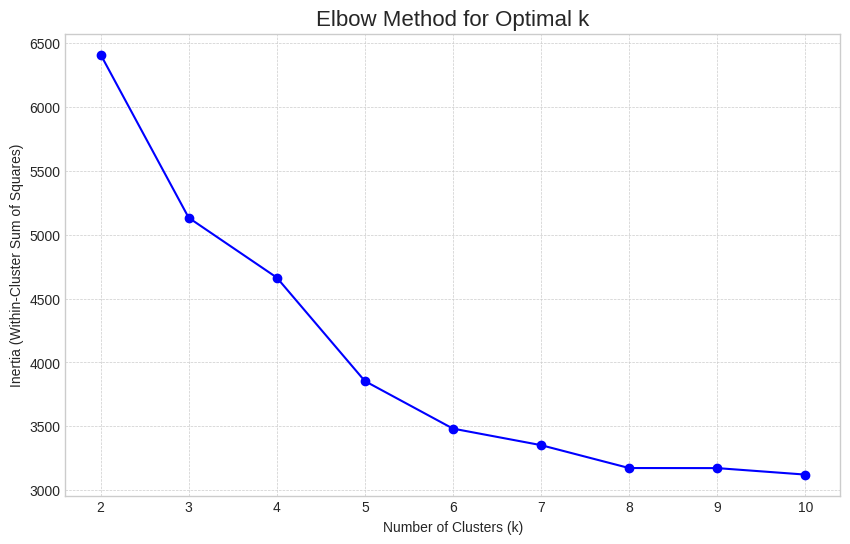

In [7]:
# ==============================================================================
#  Execute K-Means Pipeline - Step 1: Elbow Method
# ==============================================================================

def generate_elbow_plot(X_pca_df: pd.DataFrame, max_k: int = 10, random_state: int = 42):
    """
    Runs K-Means for a range of k values and plots the resulting inertia.
    """
    X_np = X_pca_df.values
    k_range = list(range(2, max_k + 1))

    print("--- Finding the Elbow ---")
    print(f"Calculating inertia for k={min(k_range)} to {max(k_range)}...")

    inertias = [kmeans_from_scratch(X_np, k, random_state=random_state)[1] for k in k_range]

    print("✅ Inertia calculation complete. Displaying Elbow Plot...")
    plot_elbow_method(k_range, inertias)

# Run the elbow plot generation.
try:
    generate_elbow_plot(X_pca_df)
except NameError as e:
    print(f"\n❌ Error: A required DataFrame was not found ({e}). Please ensure the PCA section has run successfully.")


--- Final Cluster Generation ---
Based on the Elbow Plot, which k would you like to use for the final model? 5

Generating final model for k=5...
Convergence reached after 37 iterations for k=5.
Final inertia for k=5: 3,853.67

✅ Final Summary Table (PCs + Cluster Label):


,PC1,PC2,PC3,PC4,Cluster
Customer,,,,,
1,-0.839152,5.179670,1.378952,1.147286,4
2,0.039868,-0.777031,-0.393870,-0.752068,2
3,-7.971796,0.932638,0.633477,-0.584657,3
4,-4.409624,-0.276240,0.045659,-0.089032,3
5,-3.475961,-0.793329,-0.765547,-0.008150,3



Plotting average usage profiles for 5 clusters...


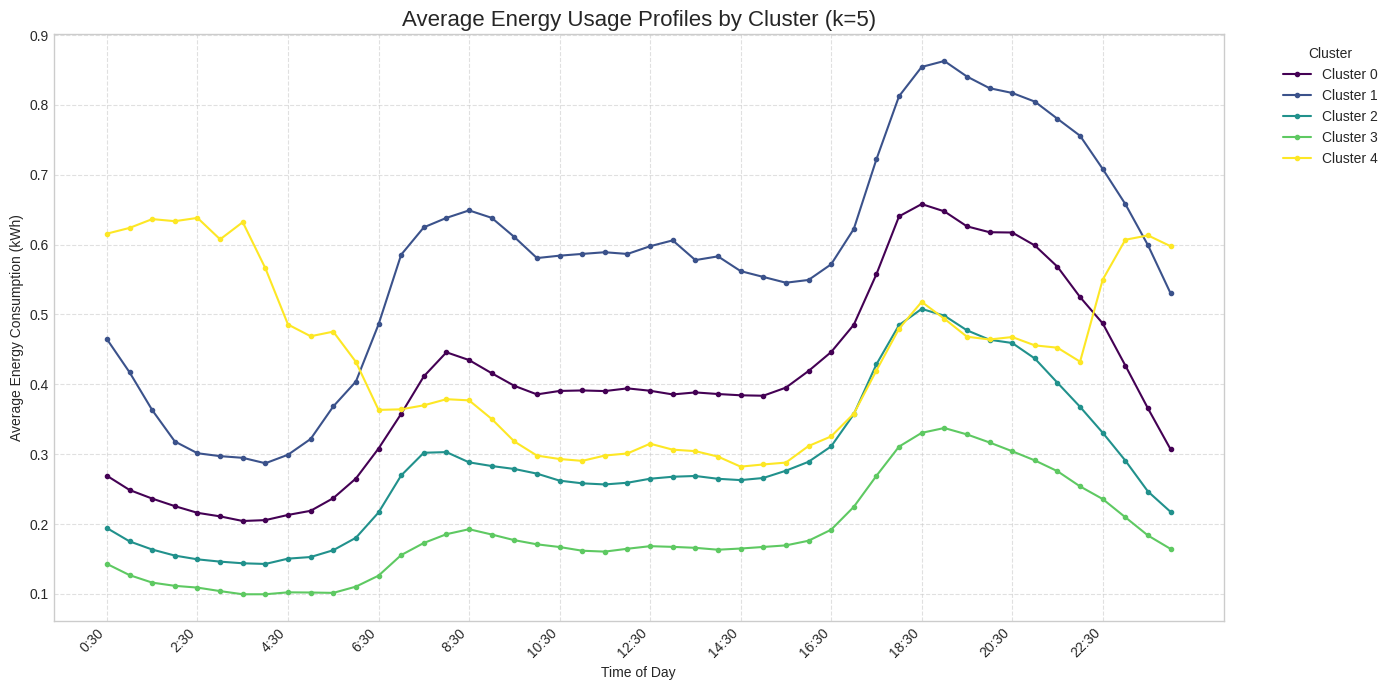


Plotting scatter plot for 5 clusters...


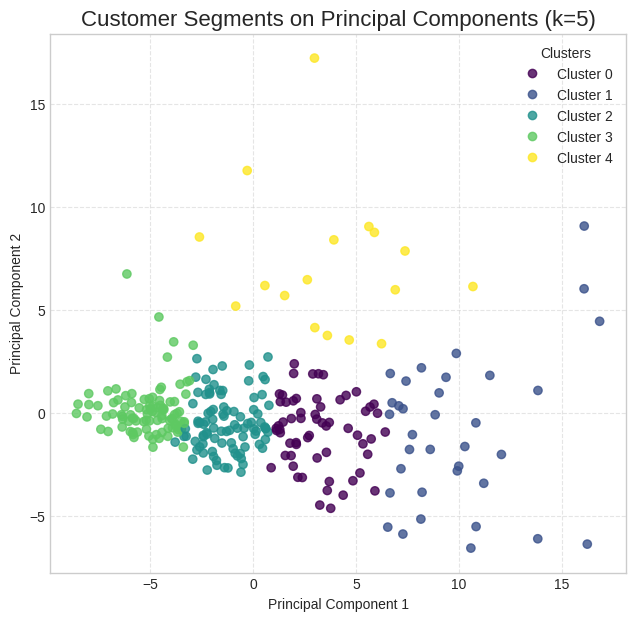


✅ K-Means analysis completed successfully.


In [8]:
# ==============================================================================
#  Execute K-Means Pipeline - Step 2: Final Model and Visualization
# ==============================================================================

try:
    print("\n--- Final Cluster Generation ---")
    chosen_k_str = input("Based on the Elbow Plot, which k would you like to use for the final model? ")
    chosen_k = int(chosen_k_str)

    print(f"\nGenerating final model for k={chosen_k}...")

    final_labels, final_inertia = kmeans_from_scratch(
        X_pca_df.values,
        k=chosen_k,
        random_state=42, # Use the same random state for consistency
        verbose=True
    )
    print(f"Final inertia for k={chosen_k}: {final_inertia:,.2f}")

    # Create and display summary results and plots.
    summary_table = create_summary_table(X_pca_df, final_labels)
    print("\n✅ Final Summary Table (PCs + Cluster Label):")
    display(summary_table.head())

    print(f"\nPlotting average usage profiles for {chosen_k} clusters...")
    plot_cluster_profiles(chosen_k, final_labels, final_profiles)

    print(f"\nPlotting scatter plot for {chosen_k} clusters...")
    plot_cluster_scatter(chosen_k, final_labels, X_pca_df)

    print("\n✅ K-Means analysis completed successfully.")

except NameError as e:
    print(f"\n❌ Error: A required DataFrame was not found ({e}). Please ensure all previous sections have run.")
except ValueError:
    print("\n❌ Invalid input. Please enter a single whole number (e.g., '4').")
except Exception as e:
    print(f"\n❌ An unexpected error occurred: {e}")